Задание 1 [4 балла].

Напишите функцию, на вход который поступает название города и которая выдает прогноз погоды на сегодня и завтра.
В прогноз включить температуру, осадки, влажность и скорость ветра.

In [1]:
import requests
from bs4 import BeautifulSoup

In [14]:
def give_weather(city_name: str):
    weather_url = f"https://yandex.ru/pogoda/{city_name.strip().lower()}/details/10-day-weather?via=ms"
    weather_response = requests.get(weather_url)
    weather_soup = BeautifulSoup(weather_response.text, 'html.parser') 
    
    # берем первые два блока: сегодня и завтра 
    table_name = "weather-table__body"
    weather_info = weather_soup.find_all('tbody', {'class': table_name})[:2]
    print(f'Погода в {city_name}:\n')
    for i, weather in enumerate(weather_info):
        print('\tСегодня:\n' if i == 0 else '\tЗавтра:\n')
        deg_cell_name = 'weather-table__body-cell weather-table__body-cell_type_daypart weather-table__body-cell_wrapper'
        degrees = weather.find_all('td', {'class': deg_cell_name})[1].find('span', {'class': 'a11y-hidden'}).text.split()
        print(f'\t\tТемпература: {degrees[2 if len(degrees) == 5 else 1]}\n')
        
        precip_cell_name = 'weather-table__body-cell weather-table__body-cell_type_condition'
        precipitation = weather.find_all('td', {'class': precip_cell_name})[1].text
        print(f'\t\tОсадки: {precipitation}\n')
        
        humidity_cell_name = 'weather-table__body-cell weather-table__body-cell_type_humidity'
        humidity = weather.find_all('td', {'class': humidity_cell_name})[1].text
        print(f'\t\tВлажность: {humidity}\n')
        
        wind_cell_name = 'weather-table__body-cell weather-table__body-cell_type_wind weather-table__body-cell_wrapper'
        wind = weather.find_all('td', {'class': wind_cell_name})[1].text
        print(f'\t\tВетер: {wind}\n')     

In [15]:
give_weather('moscow')

Погода в moscow:

	Сегодня:

		Температура: -3

		Осадки: Пасмурно

		Влажность: 74%

		Ветер: 3,1ЮВ3, юго-восточный

	Завтра:

		Температура: -5

		Осадки: Пасмурно

		Влажность: 86%

		Ветер: 1,9В2, восточный



In [16]:
give_weather('yekaterinburg')

Погода в yekaterinburg:

	Сегодня:

		Температура: -6

		Осадки: Облачно с прояснениями

		Влажность: 56%

		Ветер: 5,2З5, западный

	Завтра:

		Температура: -6

		Осадки: Пасмурно

		Влажность: 66%

		Ветер: 6,9З7, западный



Задание 2 [2 балла].

Воспользуйтесь рейтингом фильмов - https://www.imdb.com/chart/top
Выгрузите ранг фильма, название, год и рейтинг.
1. Определите самое успешное десятилетие на основе среднего и максимального рейтинга фильмов (например, десятилетием является период 2010-2019 включительно). Постройте график.
2. Выведите таблицу в формате: Десятилетие - Самый успешый фильм этого десятилетия

In [17]:
imdb_url = "https://www.imdb.com/chart/top"
imdb_response = requests.get(imdb_url)
imdb_soup = BeautifulSoup(imdb_response.text, 'html.parser')

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
data = []
top_list = imdb_soup.find('tbody', {'class': 'lister-list'})
for film in top_list.find_all('tr'):
    title_cell = film.find('td', {'class': 'titleColumn'})
    info = title_cell.text.replace('\n', '')
    idx = info.rfind('(')
    year = int(info[idx+1:idx+5])
    info = info[:idx].split()
    rating = film.find('td', {'class': 'ratingColumn'}).text.strip()
    data.append([info[0][:-1], " ".join(info[1:]), year, float(rating)])
data = pd.DataFrame(data, columns=['rang', 'name', 'year', 'rating'])
data.set_index(data.columns[0], inplace=True)
data
    

,name,year,rating
rang,,,
1,Побег из Шоушенка,1994,9.2
2,Крёстный отец,1972,9.2
3,Темный рыцарь,2008,9.0
4,Крёстный отец 2,1974,9.0
5,12 рaзгневанных мужчин,1957,9.0
...,...,...,...
246,Дерсу Узала,1975,8.0
247,Прислуга,2011,8.0
248,Аладдин,1992,8.0


In [20]:
min(data['year'])

1921

In [21]:
decades = list(range(1920, 2021, 10))
avg_ratings = []
for decade in decades:
    decade_data = data[(data['year'] >= decade) & (data['year'] < decade + 10)]
    avg_ratings.append(np.round(decade_data['rating'].mean(), 3))

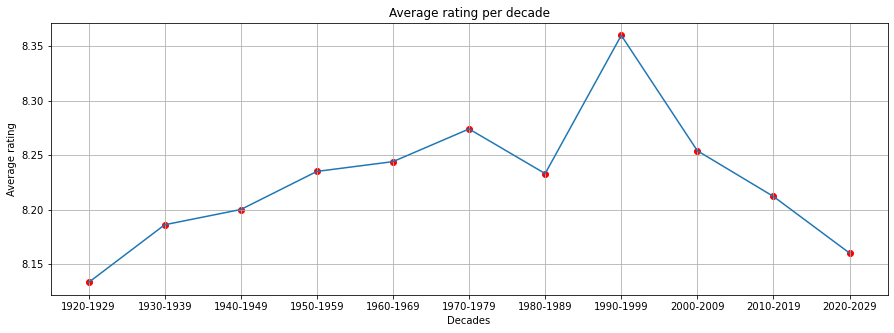

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(range(len(avg_ratings)), avg_ratings)
plt.grid()
plt.title('Average rating per decade')
plt.scatter(range(len(avg_ratings)), avg_ratings, c='red')
plt.ylabel('Average rating')
plt.xlabel('Decades')
plt.xticks(range(len(decades)), [str(decade)+'-'+str(decade+9) for decade in decades]);

Получается, что 1990-1999 самое успешное десятилетие

В следующем пункте дан топ лист => даже не надо сортировать

In [23]:
sucessful_films = []
sucessful_ratings = []
for decade in decades:
    decade_data = data[(data['year'] >= decade) & (data['year'] < decade + 10)]
    max_rating = decade_data['rating'][0]
    sucessful_ratings.append(max_rating)
    decade_data.reset_index(drop=True, inplace=True)
    cur_sucessful = decade_data.iloc[0]['name']
    i = 1
    while decade_data.iloc[i]['rating'] == max_rating:
        cur_sucessful += '; '
        cur_sucessful += decade_data.iloc[i]['name']
        i += 1
    sucessful_films.append(cur_sucessful)
data_sucessful = pd.DataFrame({'decade':  [str(decade)+'-'+str(decade+9) for decade in decades],
                               'most sucessful': sucessful_films,
                               'rating': sucessful_ratings})
data_sucessful

,decade,most sucessful,rating
0,1920-1929,Метрополис; Малыш,8.2
1,1930-1939,Новые времена; Огни большого города,8.4
2,1940-1949,Эта замечательная жизнь,8.6
3,1950-1959,12 рaзгневанных мужчин,9.0
4,1960-1969,"Хороший, плохой, злой",8.8
5,1970-1979,Крёстный отец,9.2
6,1980-1989,Звёздные войны. Эпизод 5: Империя наносит отве...,8.7
7,1990-1999,Побег из Шоушенка,9.2
8,2000-2009,Темный рыцарь,9.0
9,2010-2019,Начало,8.7


Задание 3 [4 балла].

Напишите скрипт, который будет нажимать на случайную внутреннюю ссылку на странице Википедии. Внутренней считается ссылка, которая ссылается на какую-то другую статью Википедии.
Ссылка должна быть из основного информационного блока. Функциональные ссылки из верхнего, бокового и нижнего меню в этой процедуре участвовать не должны.

На вход функции поступает число повторений этой процедуры. Переходы не прерываются, то есть при переходе на следующую статью следующая ссылка выбирается именно среди ссылок этой статьи.

Выведите путь (последовательность) по названиям статей, которые встретились в процессе перехода по страницам.

In [ ]:
vector-body

In [27]:
def wiki_walk(num_iter):
    wiki_url = 'https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D0%B0%D1%8F_%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B8%D1%86%D0%B0'
    for i in range(num_iter):
        wiki_response = requests.get(wiki_url)
        wiki_soup = BeautifulSoup(wiki_response.text, 'html.parser')
        print('|', wiki_soup.title.text, '|', sep='')
        body = wiki_soup.find('div', {'class': 'main-wrapper' if i == 0 else 'mw-body-content mw-content-ltr'})
        links = body.find_all('a', href=True)
        idx = np.random.choice(len(links))
        wiki_url = 'https://ru.wikipedia.org' + links[idx]['href']
        if i != num_iter - 1:
            print('Переход на', wiki_url)

In [28]:
wiki_walk(5)

|Википедия — свободная энциклопедия|
Переход на https://ru.wikipedia.org/wiki/%D0%9C%D0%B0%D0%B9%D0%BE%D1%80_%D0%93%D1%80%D0%BE%D0%BC_(%D1%84%D0%B8%D0%BB%D1%8C%D0%BC)
|Майор Гром (фильм) — Википедия|
Переход на https://ru.wikipedia.org/wiki/%D0%A2%D1%80%D0%B5%D0%B9%D0%BB%D0%B5%D1%80_(%D0%BA%D0%B8%D0%BD%D0%B5%D0%BC%D0%B0%D1%82%D0%BE%D0%B3%D1%80%D0%B0%D1%84)
|Трейлер (кинематограф) — Википедия|
Переход на https://ru.wikipedia.org/wiki/Kodak
|Eastman Kodak — Википедия|
Переход на https://ru.wikipedia.org/wiki/%D0%92%D1%8C%D0%B5%D1%82%D0%BD%D0%B0%D0%BC%D1%81%D0%BA%D0%B0%D1%8F_%D0%B2%D0%BE%D0%B9%D0%BD%D0%B0
|Война во Вьетнаме — Википедия|
